In [2]:
pip install infomap

     ---------------------------------------- 0.0/562.0 kB ? eta -:--:--
      --------------------------------------- 10.2/562.0 kB ? eta -:--:--
      --------------------------------------- 10.2/562.0 kB ? eta -:--:--
     -- ---------------------------------- 30.7/562.0 kB 217.9 kB/s eta 0:00:03
     -- ---------------------------------- 30.7/562.0 kB 217.9 kB/s eta 0:00:03
     ---- -------------------------------- 61.4/562.0 kB 252.2 kB/s eta 0:00:02
     ------- ---------------------------- 112.6/562.0 kB 409.6 kB/s eta 0:00:02
     ------- ---------------------------- 122.9/562.0 kB 423.5 kB/s eta 0:00:02
     --------------- -------------------- 235.5/562.0 kB 654.9 kB/s eta 0:00:01
     ---------------- ------------------- 256.0/562.0 kB 682.7 kB/s eta 0:00:01
     ----------------------- ------------ 368.6/562.0 kB 818.3 kB/s eta 0:00:01
     ------------------------ ----------- 389.1/562.0 kB 836.4 kB/s eta 0:00:01
     ------------------------------- ---- 491.5/562.0 kB 87


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# -- Bib
import os
import sys
sys.path.append("..")

import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from fluxsus.DBFIX import DBFIX
from fluxsus.fluxnets.fluxnets import CityFlux, CityHospitalFlux
from fluxsus.utils_ import f_infomap
from scipy.stats import linregress

PyTables is not installed. No support for HDF output.


In [4]:
# -- Open the three main datasets: CNES, CE GEODATA, SIHSUS.
basepath = os.path.join(os.environ["HOMEPATH"], "Documents", "data")
cnespath = os.path.join(basepath, "opendatasus", "cnes")
sihpath = os.path.join(basepath, "opendatasus", "sihsus", "PARQUET")
geopath = os.path.join(basepath, "shapefilesceqgis")
gml_folder = os.path.join(basepath, "redes_aih")

In [3]:
pop_df = pd.read_excel(os.path.join(geopath, "POP. MUNICIPIO CEARA_ 2009_2023.xlsx"), header=4)[1:-3]
pop_df.columns = ['GEOCOD6','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022', '2022.1']
pop_df["GEOCOD6"] = pop_df["GEOCOD6"].apply(lambda x: x.split(" ")[0])
pop_df["2018-2022(MEAN)"] = pop_df[['2018', '2019','2020','2021','2022']].apply(lambda x: np.mean(x.values), axis=1)
pop_df.head()

,GEOCOD6,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2022.1,2018-2022(MEAN)
1,230010,10483.0,10668.0,10790.0,10908.0,11023.0,11137.0,11259.0,11380.0,11498.0,11619.0,11737.0,11853.0,11965.0,10038.0,10038.0,11442.4
2,230015,13766.0,13938.0,14050.0,14162.0,14266.0,14372.0,14486.0,14598.0,14707.0,14820.0,14929.0,15036.0,15140.0,14027.0,14027.0,14790.4
3,230020,57606.0,58349.0,58837.0,59313.0,59773.0,60230.0,60722.0,61208.0,61679.0,62165.0,62641.0,63104.0,63556.0,64806.0,64806.0,63254.4
4,230030,51971.0,52311.0,52532.0,52750.0,52961.0,53169.0,53393.0,53616.0,53830.0,54052.0,54270.0,54481.0,54687.0,44962.0,44962.0,52490.4
5,230040,16382.0,16532.0,16631.0,16727.0,16820.0,16912.0,17012.0,17110.0,17205.0,17303.0,17399.0,17493.0,17584.0,14076.0,14076.0,16771.0


In [4]:
geodata_df = gpd.read_parquet(os.path.join(geopath, "ce_geodata.parquet"))
#geodata_df = geodata_df.merge(pop_df[["GEOCOD6", "2018-2022(MEAN)"]], on="GEOCOD6", how="left")


In [13]:
fname = "CITYFLUX_2013_2022_ALL.gml"
graph = nx.read_gml(os.path.join(gml_folder, "novo", fname))

# -- aggregate incoming information
for u in graph.nodes():
    in_edges = [ e for e in graph.in_edges(u) ]
    graph.nodes[u]['incoming_people'] = 0
    graph.nodes[u]['incoming_cost'] = 0
    for e in in_edges:
        graph.nodes[u]['incoming_people'] += graph.edges[e]['admission_count']
        graph.nodes[u]['incoming_cost'] += graph.edges[e]['total_cost']

# -- create new weight based on the number of hospital beds
for u, v in graph.edges():
    numleitos = graph.nodes[u]['numleitos']
    graph.edges[(u,v)]['outflow_per_hospbed'] = graph.edges[(u,v)]['admission_count']/numleitos
    

# -- community algorithms
module_count = f_infomap(graph, weight_col='admission_count')
module_count_hospbed = f_infomap(graph, weight_col='outflow_per_hospbed')
module_cost = f_infomap(graph, weight_col='total_cost')

louvain_modules_count = nx.community.louvain_communities(graph, weight='admission_count')
louvain_modules_cost = nx.community.louvain_communities(graph, weight='total_cost')

# -- include new modularization and inflow information to nodes
module_count_code, module_cost_code = {}, {}
module_count_n, module_cost_n = {}, {}
for u in graph.nodes():
    module_count_code.update({ graph.nodes[u]['municipio_code'] : module_count[int(u)] })
    module_cost_code.update({ graph.nodes[u]['municipio_code'] : module_cost[int(u)] })

    module_count_n.update({ graph.nodes[u]['municipio_code'] : graph.nodes[u]['incoming_people'] })
    module_cost_n.update({ graph.nodes[u]['municipio_code'] : graph.nodes[u]['incoming_cost'] })

# -- infomap node info
for u in graph.nodes():
    graph.nodes[u]['infomap_count_module_id'] = module_count[int(u)]
    graph.nodes[u]['infomap_count_per_leito_module_id'] = module_count_hospbed[int(u)]
    graph.nodes[u]['infomap_cost_module_id'] = module_cost[int(u)]

# -- louvain node info
for module_index, nodes in enumerate(louvain_modules_count):
    for node in list(nodes):
        graph.nodes[node]['louvain_count_module_id'] = module_index+1

for module_index, nodes in enumerate(louvain_modules_cost):
    for node in list(nodes):
        graph.nodes[node]['louvain_cost_module_id'] = module_index+1


geodata_df["INFOMAP_COUNT_MODULE"] = geodata_df["GEOCOD6"].map(module_count_code)
geodata_df["INFOMAP_COST_MODULE"] = geodata_df["GEOCOD6"].map(module_cost_code)

# -- transform louvain format
louvain_modules_count_dict = {}
for index, nodes in enumerate(louvain_modules_count):
    for node in list(nodes):
        louvain_modules_count_dict.update({graph.nodes[node]['municipio_code'] : index+1})
louvain_modules_cost_dict = {}
for index, nodes in enumerate(louvain_modules_cost):
    for node in list(nodes):
        louvain_modules_cost_dict.update({graph.nodes[node]['municipio_code'] : index+1})
geodata_df["LOUVAIN_COUNT_MODULE"] = geodata_df["GEOCOD6"].map(louvain_modules_count_dict)
geodata_df["LOUVAIN_COST_MODULE"] = geodata_df["GEOCOD6"].map(louvain_modules_cost_dict)
geodata_df["INFLOW_PEOPLE"] = geodata_df["GEOCOD6"].map(module_count_n)
geodata_df["INFLOW_COST"] = geodata_df["GEOCOD6"].map(module_cost_n)

found 9 modules with codelength: 2.4984634636108685
found 10 modules with codelength: 2.5027684555697385
found 3 modules with codelength: 2.479820621015808


In [15]:
# -- specify base colors
# ---- original colors based on specific cities
# ---- new modules will be colored with the original colors if one of the cities below is included
cmap_macro_original = {1: "#ef476f", 2: "#ffb300", 3: "#04ae81", 4: "#118ab2", 5: "#073b4c"}
geodata_df["MACRO_COLOR"] = geodata_df["MACRO_ID"].map(cmap_macro_original)

citycode_colors = {"230440": "#ef476f", "230730": "#073b4c", "230410": "#118ab2", "231140": "#ffb300", "231180": "#04ae81"}
citylabel_colors = {"58": "#ef476f", "98": "#073b4c", "49": "#118ab2", "150": "#ffb300", "154": "#04ae81"}
extra_colors = ["#00756a", "#bcb20f", "#ff8239", "#c6881c", "#00a2a3"]

# -- create new cmap for new modules
cmap_infomap_count, cmap_infomap_cost = {}, {}
cmap_louvain_count, cmap_louvain_cost = {}, {}

# ---- INFOMAP COUNT
for v in graph.nodes():
    if graph.nodes[v]['municipio_code'] in citycode_colors.keys():
        if graph.nodes[v]['infomap_count_module_id'] not in cmap_infomap_count.keys():
            cmap_infomap_count.update({graph.nodes[v]['infomap_count_module_id'] : citycode_colors[graph.nodes[v]['municipio_code']]})
extra_colors_ = extra_colors[:] + [ x for x in citycode_colors.values() if x not in cmap_infomap_count.values() ]
dummy_index = 0
for n in range(10):
    if n+1 not in cmap_infomap_count.keys():
        cmap_infomap_count.update({ n+1: extra_colors_[dummy_index]})
        dummy_index+=1

# ---- INFOMAP COUNT PER HOSP BED
for v in graph.nodes():
    if graph.nodes[v]['municipio_code'] in citycode_colors.keys():
        if graph.nodes[v]['infomap_count_per_leito_module_id'] not in cmap_infomap_count.keys():
            cmap_infomap_count.update({graph.nodes[v]['infomap_count_per_leito_module_id'] : citycode_colors[graph.nodes[v]['municipio_code']]})
extra_colors_ = extra_colors[:] + [ x for x in citycode_colors.values() if x not in cmap_infomap_count.values() ]
dummy_index = 0
for n in range(10):
    if n+1 not in cmap_infomap_count.keys():
        cmap_infomap_count.update({ n+1: extra_colors_[dummy_index]})
        dummy_index+=1

# ---- INFOMAP COST
for v in graph.nodes():
    if graph.nodes[v]['municipio_code'] in citycode_colors.keys():
        if graph.nodes[v]['infomap_cost_module_id'] not in cmap_infomap_cost.keys():
            cmap_infomap_cost.update({graph.nodes[v]['infomap_cost_module_id'] : citycode_colors[graph.nodes[v]['municipio_code']]})
extra_colors_ = extra_colors[:] + [ x for x in citycode_colors.values() if x not in cmap_infomap_cost.values() ]
dummy_index = 0
for n in range(10):
    if n+1 not in cmap_infomap_cost.keys():
        cmap_infomap_cost.update({ n+1: extra_colors_[dummy_index]})
        dummy_index+=1

# ---- LOUVAIN COUNT
for v in graph.nodes():
    if graph.nodes[v]['municipio_code'] in citycode_colors.keys():
        if graph.nodes[v]['louvain_count_module_id'] not in cmap_louvain_count.keys():
            cmap_louvain_count.update({graph.nodes[v]['louvain_count_module_id'] : citycode_colors[graph.nodes[v]['municipio_code']]})
extra_colors_ = extra_colors[:] + [ x for x in citycode_colors.values() if x not in cmap_louvain_count.values() ]
dummy_index = 0
for n in range(10):
    if n+1 not in cmap_louvain_count.keys():
        cmap_louvain_count.update({ n+1: extra_colors_[dummy_index]})
        dummy_index+=1

# ---- LOUVAIN COST
for v in graph.nodes():
    if graph.nodes[v]['municipio_code'] in citycode_colors.keys():
        if graph.nodes[v]['louvain_cost_module_id'] not in cmap_louvain_cost.keys():
            cmap_louvain_cost.update({graph.nodes[v]['louvain_cost_module_id'] : citycode_colors[graph.nodes[v]['municipio_code']]})
extra_colors_ = extra_colors[:] + [ x for x in citycode_colors.values() if x not in cmap_louvain_cost.values() ]
dummy_index = 0
for n in range(10):
    if n+1 not in cmap_louvain_cost.keys():
        cmap_louvain_cost.update({ n+1: extra_colors_[dummy_index]})
        dummy_index+=1


geodata_df["INFOMAP_COUNT_COLOR"] = geodata_df["INFOMAP_COUNT_MODULE"].map(cmap_infomap_count)
geodata_df["INFOMAP_COST_COLOR"] = geodata_df["INFOMAP_COST_MODULE"].map(cmap_infomap_count)
geodata_df["LOUVAIN_COUNT_COLOR"] = geodata_df["LOUVAIN_COUNT_MODULE"].map(cmap_louvain_count)
geodata_df["LOUVAIN_COST_COLOR"] = geodata_df["LOUVAIN_COST_MODULE"].map(cmap_louvain_cost)

In [16]:
geodata_df

,GEOCOD7,NM_MUNICIP,GEOCOD6,MACRO_ID,CRES_ID,geometry_municip,MACRO_NOME,geometry_macro,geometry_cres,centroid_municip,...,INFOMAP_COST_MODULE,LOUVAIN_COUNT_MODULE,LOUVAIN_COST_MODULE,INFLOW_PEOPLE,INFLOW_COST,INFOMAP_COUNT_COLOR,INFOMAP_COST_COLOR,LOUVAIN_COUNT_COLOR,LOUVAIN_COST_COLOR,MACRO_COLOR
0,2300101,ABAIARA,230010,5,19,"POLYGON ((-39.08246 -7.29577, -39.08347 -7.292...",Superintendência Regional de Saúde Cariri,"POLYGON ((-38.67306 -6.70700, -38.67306 -6.707...","POLYGON ((-4354692.823 -865196.973, -4354812.2...",POINT (-39.03754 -7.35991),...,4,5,3,0,0.00,#ffb300,#bcb20f,#073b4c,#073b4c,#073b4c
1,2300150,ACARAPE,230015,1,3,"POLYGON ((-38.67268 -4.27393, -38.67268 -4.273...",Superintendência Regional de Saúde Fortaleza,"MULTIPOLYGON (((-39.69667 -2.99902, -39.69216 ...","POLYGON ((-4325426.833 -465433.632, -4325426.8...",POINT (-38.66305 -4.22242),...,1,3,1,0,0.00,#ef476f,#ef476f,#ef476f,#ef476f,#ef476f
2,2300200,ACARAÚ,230020,4,12,"POLYGON ((-39.99113 -3.09797, -39.99117 -3.098...",Superintendência Regional de Saúde Norte,"MULTIPOLYGON (((-39.90892 -3.27414, -39.90892 ...","POLYGON ((-4503430.806 -312287.468, -4503430.7...",POINT (-40.08913 -2.96792),...,1,8,4,17363,8068917.01,#00756a,#ef476f,#118ab2,#118ab2,#118ab2
3,2300309,ACOPIARA,230030,5,18,"POLYGON ((-39.21390 -5.99175, -39.21278 -5.991...",Superintendência Regional de Saúde Cariri,"POLYGON ((-38.67306 -6.70700, -38.67306 -6.707...","POLYGON ((-4440719.425 -681940.298, -4440964.9...",POINT (-39.49282 -6.12241),...,4,5,3,1540,874934.14,#c6881c,#bcb20f,#073b4c,#073b4c,#073b4c
4,2300408,AIUABA,230040,2,14,"POLYGON ((-40.14849 -6.36051, -40.14816 -6.360...",Superintendência Regional de Saúde Sertão Central,"POLYGON ((-40.08511 -6.36860, -40.08445 -6.370...","POLYGON ((-4448196.104 -680357.114, -4447996.7...",POINT (-40.29895 -6.60520),...,1,6,1,66,29856.46,#ef476f,#ef476f,#c6881c,#ef476f,#ffb300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,2313807,URUBURETAMA,231380,1,6,"POLYGON ((-39.55089 -3.58253, -39.53197 -3.582...",Superintendência Regional de Saúde Fortaleza,"MULTIPOLYGON (((-39.69667 -2.99902, -39.69216 ...","POLYGON ((-4402776.237 -343001.709, -4402648.3...",POINT (-39.51578 -3.62282),...,1,4,2,16,7843.19,#ef476f,#ef476f,#ff8239,#00756a,#ef476f
180,2313906,URUOCA,231390,4,11,"POLYGON ((-40.70713 -3.23916, -40.70319 -3.240...",Superintendência Regional de Saúde Norte,"MULTIPOLYGON (((-39.90892 -3.27414, -39.90892 ...","MULTIPOLYGON (((-4518310.108 -507950.779, -451...",POINT (-40.68015 -3.32123),...,1,8,4,13,5055.99,#00756a,#ef476f,#118ab2,#118ab2,#118ab2
181,2313955,VARJOTA,231395,4,11,"POLYGON ((-40.55755 -4.20910, -40.55869 -4.208...",Superintendência Regional de Saúde Norte,"MULTIPOLYGON (((-39.90892 -3.27414, -39.90892 ...","MULTIPOLYGON (((-4518310.108 -507950.779, -451...",POINT (-40.49453 -4.16803),...,1,8,4,116,51029.24,#00756a,#ef476f,#118ab2,#118ab2,#118ab2
182,2314003,VÁRZEA ALEGRE,231400,5,17,"POLYGON ((-39.28999 -6.65783, -39.28999 -6.657...",Superintendência Regional de Saúde Cariri,"POLYGON ((-38.67306 -6.70700, -38.67306 -6.707...","POLYGON ((-4305065.442 -748330.453, -4305140.3...",POINT (-39.29801 -6.77220),...,2,5,3,4328,1955069.75,#073b4c,#073b4c,#073b4c,#073b4c,#073b4c


In [18]:
geodata_df["MACRO_COLOR"]

0      #073b4c
1      #ef476f
2      #118ab2
3      #073b4c
4      #ffb300
        ...   
179    #ef476f
180    #118ab2
181    #118ab2
182    #073b4c
183    #118ab2
Name: MACRO_COLOR, Length: 184, dtype: object

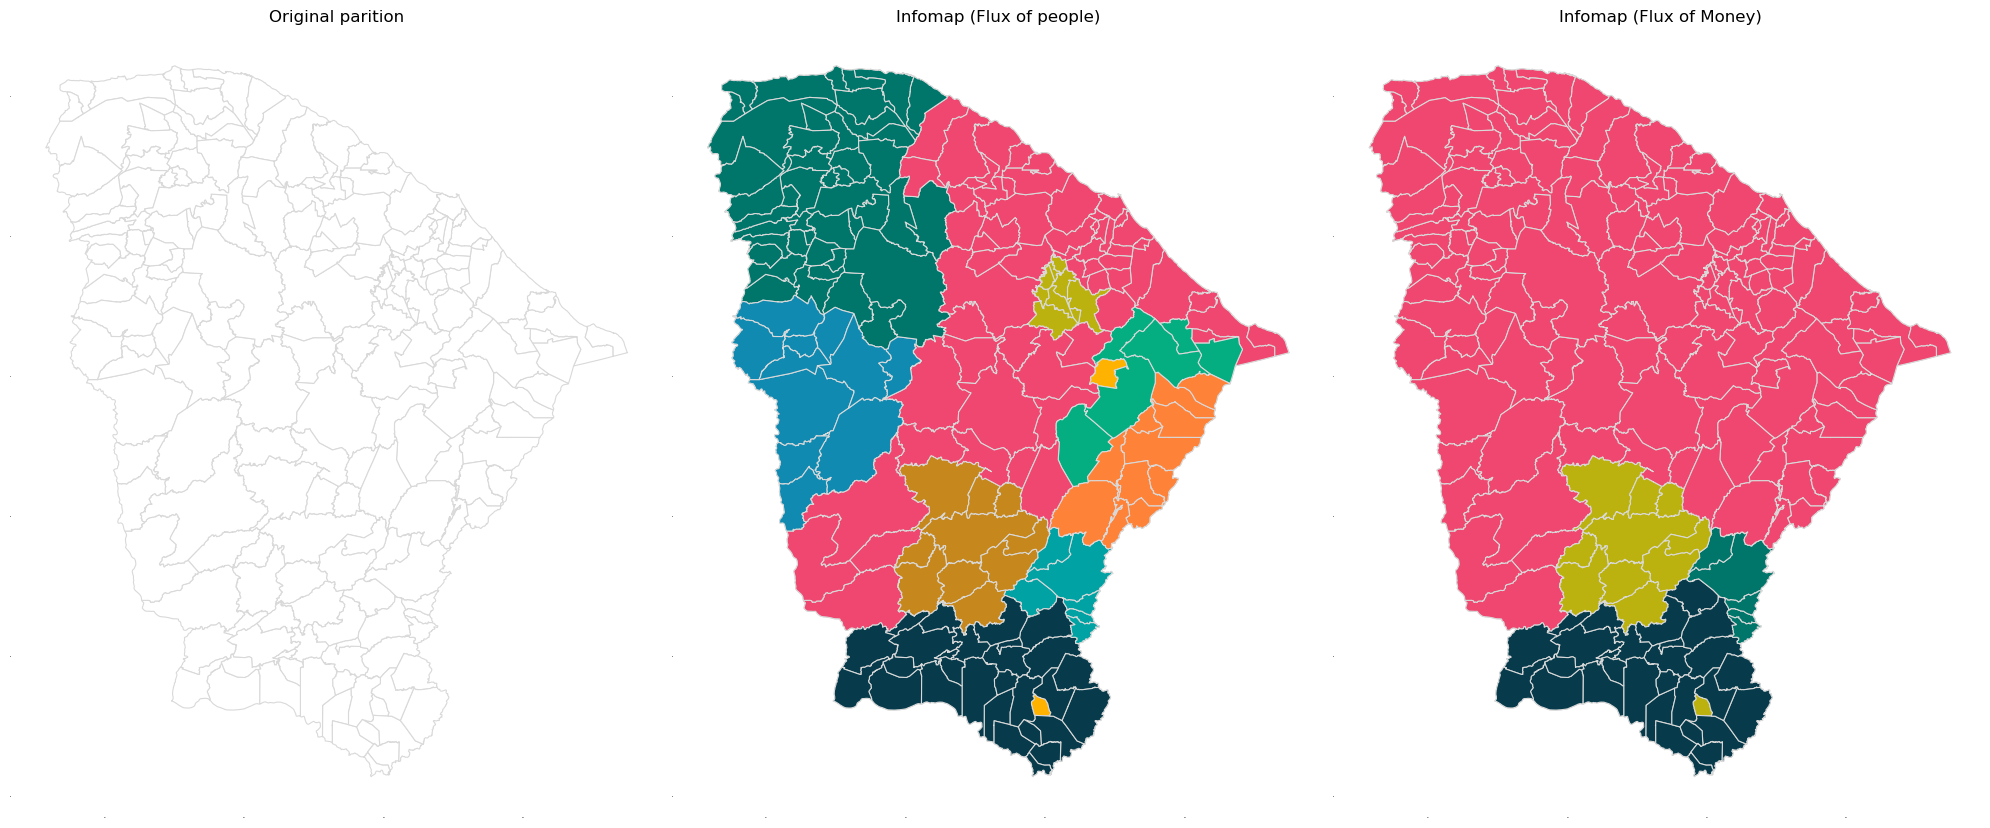

In [19]:
# -- new geometry ceará
fig_new, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,11))
#cmap_new = {1: "#b4ddd4", 2: "#294d46", 3: "#39eec0", 4: "#056e12", 5: "#a0e85b", 6: "#773493", 7: "#cf84cb", 8: "#49406e", 9: "#ef66f0"}
#cmap_new_all = {1: "#ef476f", 2: "#073b4c", 3: "#ca35b4", 4: "#1e39ae", 5: "#118ab2", 6: "#33ccff", 7: "#7220f6", 8: "#ffb300", 9: "#04ae81"}
#cmap_new_ch1 = {1: "#ef476f", 2: "#073b4c", 3: "#ca35b4", 4: "#1e39ae", 5: "#118ab2", 6: "#33ccff", 7: "#7220f6", 8: "#ffb300", 9: "#04ae81", 10: "#fca5cf"}
#cmap_new_ch2 = {1: "#ef476f", 2: "#073b4c", 3: "#ca35b4"}
#cmap_new_ch9 = {1: "#ef476f", 2: "#073b4c", 3: "#ca35b4", 4: "#1e39ae", 5: "#118ab2", 6: "#33ccff", 7: "#7220f6", 8: "#ffb300", 9: "#04ae81"}
#facecolors = mun_df2["municipio_module_id"].map(cmap_new_ch9)

geodata_df.set_geometry('geometry_municip').plot(ax=ax1, color="#ffffff", edgecolor="#d9d9d9", linewidth=0.8)
geodata_df.set_geometry('geometry_municip').plot(ax=ax2, color="#ffffff", edgecolor="#d9d9d9", linewidth=0.8)
geodata_df.set_geometry('geometry_municip').plot(ax=ax3, color="#ffffff", edgecolor="#d9d9d9", linewidth=0.8)

#geodata_df.set_geometry('geometry_municip').plot(ax=ax1, color=geodata_df["MACRO_COLOR"], edgecolor="#d9d9d9", linewidth=0.8)
geodata_df.set_geometry('geometry_municip').plot(ax=ax2, color=geodata_df["INFOMAP_COUNT_COLOR"], edgecolor="#d9d9d9", linewidth=0.8)
geodata_df.set_geometry('geometry_municip').plot(ax=ax3, color=geodata_df["INFOMAP_COST_COLOR"], edgecolor="#d9d9d9", linewidth=0.8)

for i in ['left', 'right', 'top', 'bottom']:
    for axis in [ax1, ax2, ax3]:
        axis.spines[i].set_linewidth(0)
        axis.tick_params(which='both', length=0, labelsize=0)

#fig_new.suptitle("Application of Infomap Algorithm")
ax1.set_title("Original parition")
ax2.set_title("Infomap (Flux of people)")
ax3.set_title("Infomap (Flux of Money)")

#ax_new.tick_params(which='both', length=0, labelsize=0)

fig_new.tight_layout()
#fig_new.savefig(os.path.join(gml_output, "FIGURAS", fname_infomap.split(".")[0]+"_INFOMAP.png"), dpi=300, bbox_inches='tight')

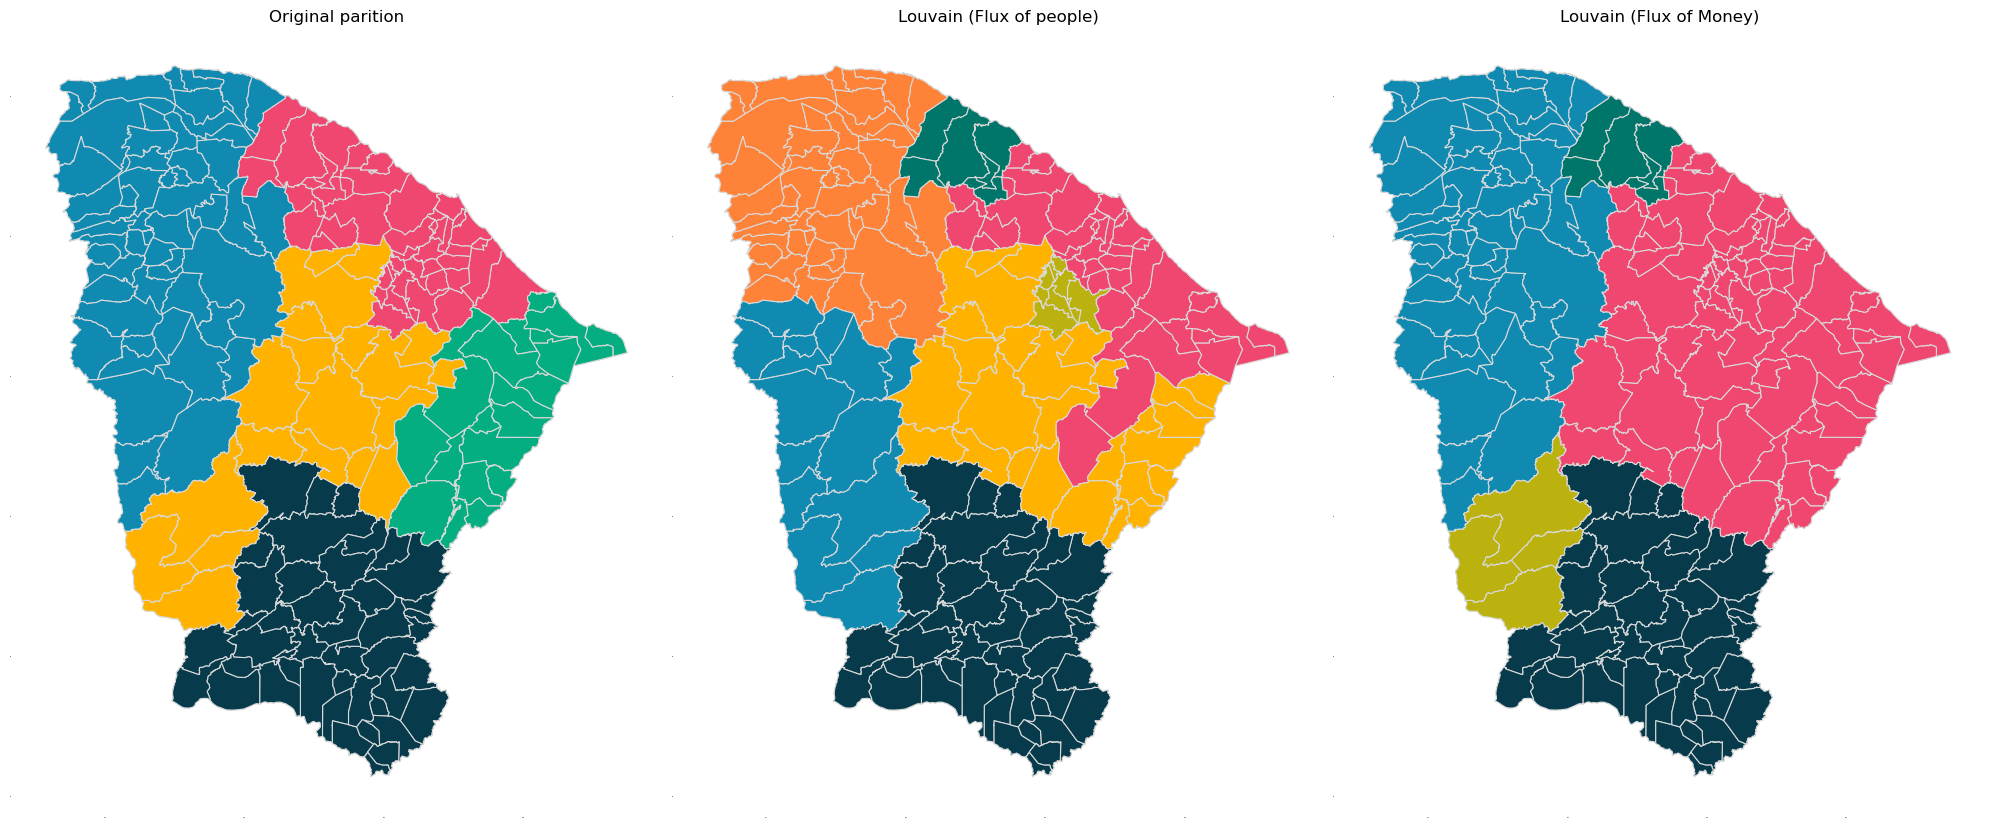

In [215]:
# -- new geometry ceará
fig_new, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,11))
#cmap_new = {1: "#b4ddd4", 2: "#294d46", 3: "#39eec0", 4: "#056e12", 5: "#a0e85b", 6: "#773493", 7: "#cf84cb", 8: "#49406e", 9: "#ef66f0"}
#cmap_new_all = {1: "#ef476f", 2: "#073b4c", 3: "#ca35b4", 4: "#1e39ae", 5: "#118ab2", 6: "#33ccff", 7: "#7220f6", 8: "#ffb300", 9: "#04ae81"}
#cmap_new_ch1 = {1: "#ef476f", 2: "#073b4c", 3: "#ca35b4", 4: "#1e39ae", 5: "#118ab2", 6: "#33ccff", 7: "#7220f6", 8: "#ffb300", 9: "#04ae81", 10: "#fca5cf"}
#cmap_new_ch2 = {1: "#ef476f", 2: "#073b4c", 3: "#ca35b4"}
#cmap_new_ch9 = {1: "#ef476f", 2: "#073b4c", 3: "#ca35b4", 4: "#1e39ae", 5: "#118ab2", 6: "#33ccff", 7: "#7220f6", 8: "#ffb300", 9: "#04ae81"}
#facecolors = mun_df2["municipio_module_id"].map(cmap_new_ch9)

geodata_df.set_geometry('geometry_municip').plot(ax=ax1, color="#ffffff", edgecolor="#d9d9d9", linewidth=0.8)
geodata_df.set_geometry('geometry_municip').plot(ax=ax2, color="#ffffff", edgecolor="#d9d9d9", linewidth=0.8)
geodata_df.set_geometry('geometry_municip').plot(ax=ax3, color="#ffffff", edgecolor="#d9d9d9", linewidth=0.8)

geodata_df.set_geometry('geometry_municip').plot(ax=ax1, color=geodata_df["MACRO_COLOR"], edgecolor="#d9d9d9", linewidth=0.8)
geodata_df.set_geometry('geometry_municip').plot(ax=ax2, color=geodata_df["LOUVAIN_COUNT_COLOR"], edgecolor="#d9d9d9", linewidth=0.8)
geodata_df.set_geometry('geometry_municip').plot(ax=ax3, color=geodata_df["LOUVAIN_COST_COLOR"], edgecolor="#d9d9d9", linewidth=0.8)

for i in ['left', 'right', 'top', 'bottom']:
    for axis in [ax1, ax2, ax3]:
        axis.spines[i].set_linewidth(0)
        axis.tick_params(which='both', length=0, labelsize=0)

#fig_new.suptitle("Application of Infomap Algorithm")
ax1.set_title("Original parition")
ax2.set_title("Louvain (Flux of people)")
ax3.set_title("Louvain (Flux of Money)")


#ax_new.tick_params(which='both', length=0, labelsize=0)

fig_new.tight_layout()

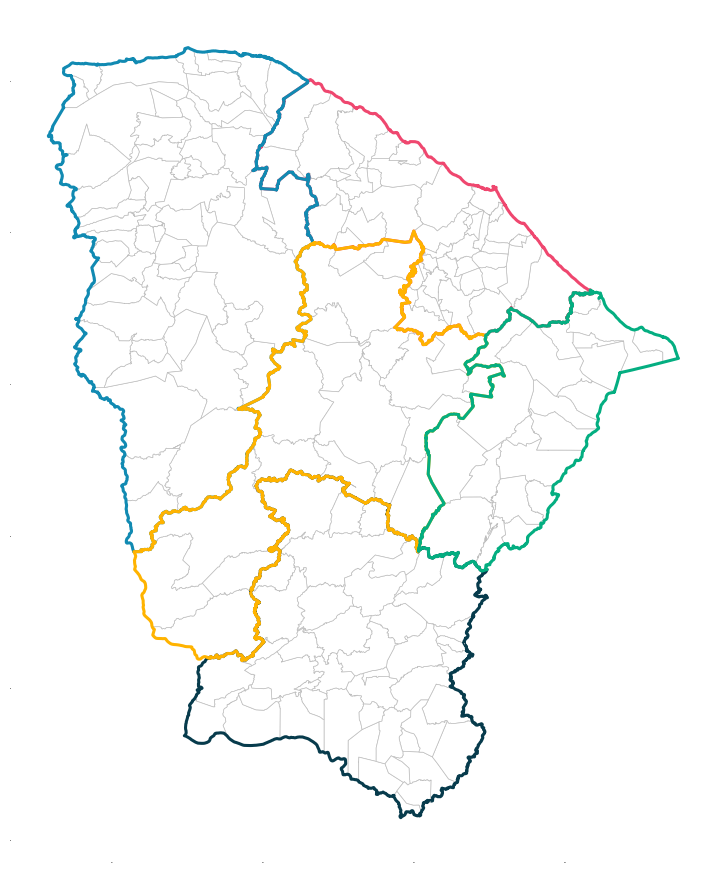

In [108]:
cmap_macro = {1: "#ef476f", 2: "#ffb300", 3: "#04ae81", 4: "#118ab2", 5: "#073b4c"}
geodata_df['MACRO_COLOR'] = geodata_df["MACRO_ID"].map(cmap_macro)
#macro_df['MACRO_COLOR'] = macro_df["ID"].map(cmap_macro)
#mun_df1.head()

# -- geometry ceará
fig1, ax1 = plt.subplots(1, figsize=(12,11))

geodata_df.set_geometry('geometry_municip').plot(ax=ax1, color="#ffffff", edgecolor="#bfbfbf", linewidth=0.5)
geodata_df.set_geometry('geometry_macro').drop_duplicates("MACRO_ID").plot(ax=ax1, color="none", edgecolor=geodata_df.drop_duplicates("MACRO_ID")["MACRO_COLOR"], linewidth=2.2)

#mun_df1.plot(ax=ax1, color="#ffffff", edgecolor="#bfbfbf", linewidth=0.5)
#macro_df.plot(ax=ax1, color="none", edgecolor=geodata_df["MACRO_COLOR"], linewidth=2.2)

for i in ['left', 'right', 'top', 'bottom']:
    ax1.spines[i].set_linewidth(0)

ax1.tick_params(which='both', length=0, labelsize=0)

In [32]:
geodata_df.set_geometry('geometry_macro').drop_duplicates("MACRO_ID")

,GEOCOD7,NM_MUNICIP,GEOCOD6,MACRO_ID,CRES_ID,geometry_municip,MACRO_NOME,geometry_macro,geometry_cres,centroid_municip,municip_lon,municip_lat,MACRO_COLOR
0,2300101,ABAIARA,230010,5,19,"POLYGON ((-39.08246 -7.29577, -39.08347 -7.292...",Superintendência Regional de Saúde Cariri,"POLYGON ((-38.67306 -6.70700, -38.67306 -6.707...","POLYGON ((-4354692.823 -865196.973, -4354812.2...",POINT (-39.03754 -7.35991),-39.037538,-7.359907,#073b4c
1,2300150,ACARAPE,230015,1,3,"POLYGON ((-38.67268 -4.27393, -38.67268 -4.273...",Superintendência Regional de Saúde Fortaleza,"MULTIPOLYGON (((-39.69667 -2.99902, -39.69216 ...","POLYGON ((-4325426.833 -465433.632, -4325426.8...",POINT (-38.66305 -4.22242),-38.663052,-4.222417,#ef476f
2,2300200,ACARAÚ,230020,4,12,"POLYGON ((-39.99113 -3.09797, -39.99117 -3.098...",Superintendência Regional de Saúde Norte,"MULTIPOLYGON (((-39.90892 -3.27414, -39.90892 ...","POLYGON ((-4503430.806 -312287.468, -4503430.7...",POINT (-40.08913 -2.96792),-40.089128,-2.967916,#118ab2
4,2300408,AIUABA,230040,2,14,"POLYGON ((-40.14849 -6.36051, -40.14816 -6.360...",Superintendência Regional de Saúde Sertão Central,"POLYGON ((-40.08511 -6.36860, -40.08445 -6.370...","POLYGON ((-4448196.104 -680357.114, -4447996.7...",POINT (-40.29895 -6.60520),-40.298951,-6.605196,#ffb300
7,2300705,ALTO SANTO,230070,3,10,"POLYGON ((-38.22391 -5.38999, -38.22076 -5.388...",Superintendência Regional de Saúde Litoral Leste,"POLYGON ((-37.77077 -4.42713, -37.76948 -4.426...","POLYGON ((-4247952.621 -660742.082, -4248308.9...",POINT (-38.20057 -5.51762),-38.200572,-5.517625,#04ae81


In [167]:
geodata_df[geodata_df["NM_MUNICIP"]=="FORTALEZA"]

,GEOCOD7,NM_MUNICIP,GEOCOD6,MACRO_ID,CRES_ID,geometry_municip,MACRO_NOME,geometry_macro,geometry_cres,centroid_municip,municip_lon,municip_lat,2018-2022(MEAN),INFOMAP_COUNT_MODULE,INFOMAP_COST_MODULE,INFLOW_PEOPLE,INFLOW_COST,MACRO_COLOR
58,2304400,FORTALEZA,230440,1,1,"POLYGON ((-38.59236 -3.70089, -38.59108 -3.699...",Superintendência Regional de Saúde Fortaleza,"MULTIPOLYGON (((-39.69667 -2.99902, -39.69216 ...","POLYGON ((-4291290.757 -433529.615, -4290910.0...",POINT (-38.52770 -3.78566),-38.527701,-3.785656,2627931.0,1,1,378362,869550234.9,#ef476f


In [48]:
graph.in_degree('0')

0

In [49]:
graph.out_degree('0')

12

In [95]:
for u in graph.nodes():
    in_edges = [ e for e in graph.in_edges(u) ]
    graph.nodes[u]['incoming_people'] = 0
    graph.nodes[u]['incoming_cost'] = 0
    for e in in_edges:
        graph.nodes[u]['incoming_people'] += graph.edges[e]['admission_count']
        graph.nodes[u]['incoming_cost'] += graph.edges[e]['total_cost']

In [94]:
[n for n in graph.in_edges('4')][0]

('3', '4')

In [111]:
def power_law_f(x, prefactor, power):
    return prefactor*(x**power)

exponent: 2.4672204367017696, prefactor: -9.004516053121526


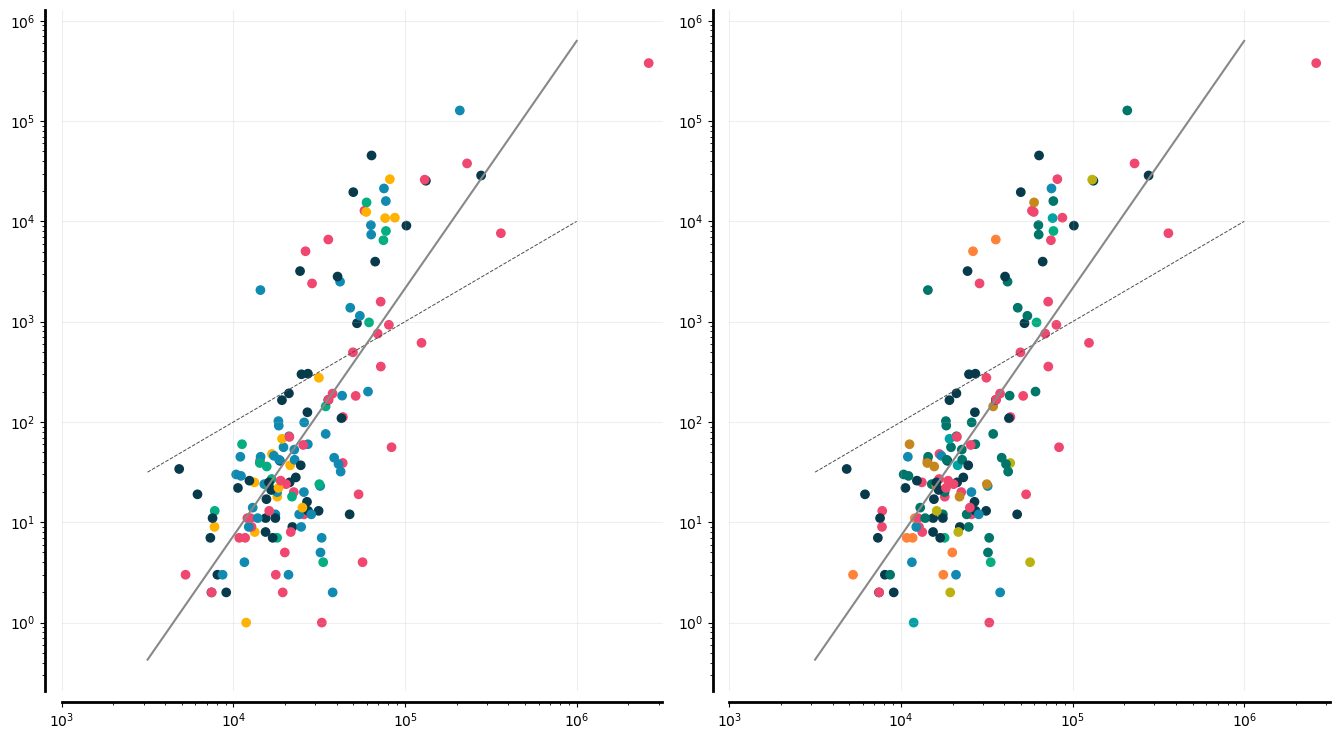

In [229]:
# -- fit
xdata = geodata_df[geodata_df["INFLOW_PEOPLE"]!=0]["2018-2022(MEAN)"]
ydata = geodata_df[geodata_df["INFLOW_PEOPLE"]!=0]["INFLOW_PEOPLE"]

res_ = linregress(np.log10(xdata.values), np.log10(ydata.values))
print(f"exponent: {res_.slope}, prefactor: {res_.intercept}")


figs, (axs11, axs12) = plt.subplots(1,2, figsize=(13.5,7.5))

axs11.grid(alpha=0.2, zorder=0)
axs12.grid(alpha=0.2, zorder=0)
# -- spines
for i in ['left', 'right', 'bottom', 'top']:
    axs11.spines[i].set_linewidth(2)
    axs12.spines[i].set_linewidth(2)

axs11.spines['top'].set_linewidth(0)
axs11.spines['right'].set_linewidth(0)
axs11.spines['bottom'].set_position(('outward', 8))
axs11.spines['left'].set_position(('outward', 12))
axs12.spines['top'].set_linewidth(0)
axs12.spines['right'].set_linewidth(0)
axs12.spines['bottom'].set_position(('outward', 8))
axs12.spines['left'].set_position(('outward', 12))

# -- slope 1
x = np.logspace(3.5, 6, 10, base=10)
y = power_law_f(x, 10**-2, 1)
axs11.plot(x, y, ls="--", color="#4d4d4d", lw=0.7)
axs12.plot(x, y, ls="--", color="#4d4d4d", lw=0.7)
# -- fitted slope
y_fit = power_law_f(x, 10**res_.intercept, res_.slope)
axs11.plot(x, y_fit, ls="-", color="#888888", lw=1.5)
axs12.plot(x, y_fit, ls="-", color="#888888", lw=1.5)

axs11.set_xlim([10**3, 10**6.5])
axs12.set_xlim([10**3, 10**6.5])

# points
axs11.scatter(geodata_df["2018-2022(MEAN)"], geodata_df["INFLOW_PEOPLE"], color=geodata_df["MACRO_COLOR"])
axs12.scatter(geodata_df["2018-2022(MEAN)"], geodata_df["INFLOW_PEOPLE"], color=geodata_df["INFOMAP_COUNT_COLOR"])
axs11.set_xscale('log')
axs11.set_yscale('log')
axs12.set_xscale('log')
axs12.set_yscale('log')

figs.tight_layout()

exponent: 2.716824101794341, prefactor: -7.386871179063773


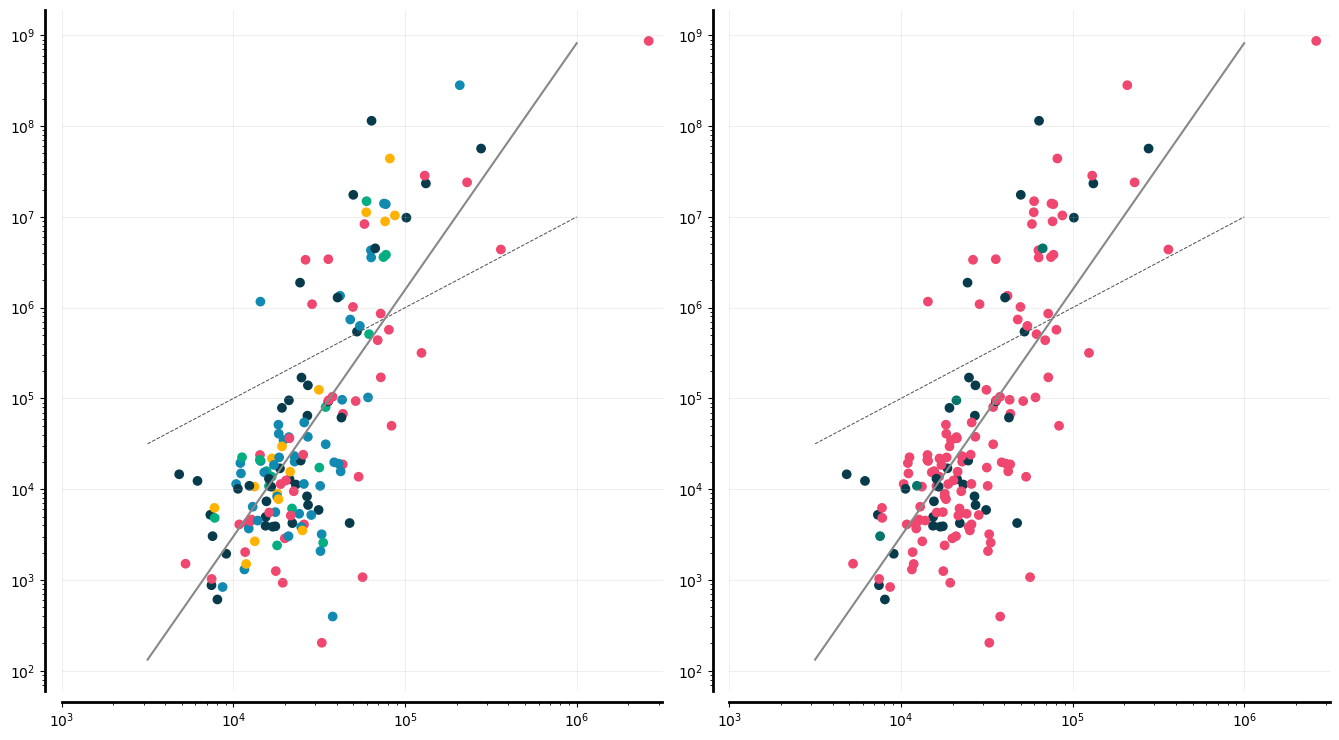

In [230]:
# -- fit
xdata = geodata_df[geodata_df["INFLOW_COST"]!=0]["2018-2022(MEAN)"]
ydata = geodata_df[geodata_df["INFLOW_COST"]!=0]["INFLOW_COST"]

res_ = linregress(np.log10(xdata.values), np.log10(ydata.values))
print(f"exponent: {res_.slope}, prefactor: {res_.intercept}")

figs, (axs11, axs12) = plt.subplots(1,2, figsize=(13.5,7.5))

axs11.grid(alpha=0.2, zorder=0)
axs12.grid(alpha=0.2, zorder=0)
# -- spines
for i in ['left', 'right', 'bottom', 'top']:
    axs11.spines[i].set_linewidth(2)
    axs12.spines[i].set_linewidth(2)

axs11.spines['top'].set_linewidth(0)
axs11.spines['right'].set_linewidth(0)
axs11.spines['bottom'].set_position(('outward', 8))
axs11.spines['left'].set_position(('outward', 12))
axs12.spines['top'].set_linewidth(0)
axs12.spines['right'].set_linewidth(0)
axs12.spines['bottom'].set_position(('outward', 8))
axs12.spines['left'].set_position(('outward', 12))

# -- slope 1
x = np.logspace(3.5, 6, 10, base=10)
y = power_law_f(x, 10**1, 1)
axs11.plot(x, y, ls="--", color="#4d4d4d", lw=0.7)
axs12.plot(x, y, ls="--", color="#4d4d4d", lw=0.7)
# -- fitted slope
y_fit = power_law_f(x, 10**res_.intercept, res_.slope)
axs11.plot(x, y_fit, ls="-", color="#888888", lw=1.5)
axs12.plot(x, y_fit, ls="-", color="#888888", lw=1.5)

axs11.set_xlim([10**3, 10**6.5])
axs12.set_xlim([10**3, 10**6.5])

# points
axs11.scatter(geodata_df["2018-2022(MEAN)"], geodata_df["INFLOW_COST"], color=geodata_df["MACRO_COLOR"])
axs12.scatter(geodata_df["2018-2022(MEAN)"], geodata_df["INFLOW_COST"], color=geodata_df["INFOMAP_COST_COLOR"])
axs11.set_xscale('log')
axs11.set_yscale('log')
axs12.set_xscale('log')
axs12.set_yscale('log')

figs.tight_layout()

In [128]:
xdata = geodata_df[geodata_df["INFLOW_PEOPLE"]!=0]["2018-2022(MEAN)"]
ydata = geodata_df[geodata_df["INFLOW_PEOPLE"]!=0]["INFLOW_PEOPLE"]

res_ = linregress(np.log10(xdata.values), np.log10(ydata.values))